Cell 1: Initial Setup with SeisBench Download

In [ ]:
# -*- coding: utf-8 -*-
"""
This notebook processes the INSTANCE dataset to create event-based groupings
and prepares data files for 50 different random event-based splits.
And uses SeisBench to download INSTANCE dataset directly to avoid Google Drive quota issues.
"""

# Install and import required packages
!pip install seisbench
!pip install torch torchvision torchaudio
!pip install h5py pandas tqdm matplotlib torchinfo seaborn

from google.colab import drive
import time
import os
import numpy as np
import pandas as pd
import h5py
from tqdm import tqdm
import torch
from collections import defaultdict
import random
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal
import seisbench.data as sbd

# Start time
start_time = time.time()

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Mount Google Drive for output directory only
drive.mount('/content/drive')

# Set SeisBench to use local VM storage (not Google Drive) to avoid quota issues
os.environ['SEISBENCH_CACHE_ROOT'] = '/content/.seisbench'
print(f"SeisBench cache root: {os.environ['SEISBENCH_CACHE_ROOT']}")

# Download INSTANCE dataset using SeisBench
print("Downloading INSTANCE dataset using SeisBench...")
print("This will download to local VM storage, avoiding Google Drive quota issues...")
instance = sbd.InstanceCounts()

# # Define the paths to local data files
# metadata_path = "/content/drive/My Drive/INSTANCE_Dataset/metadata.csv"
# hdf5_path = "/content/drive/My Drive/INSTANCE_Dataset/waveforms.hdf5"

# Get paths to the downloaded files
instance_path = instance.path
metadata_path = os.path.join(instance_path, "metadata.csv")
hdf5_path = os.path.join(instance_path, "waveforms.hdf5")

# Output directory (still on Google Drive for results)
output_dir = "/content/drive/My Drive/2023-2024/UCL MSc in DSML/Term 3/MSc Project/Code/INSTANCE_Event_Based/Lower_Half_EpiDis"
os.makedirs(output_dir, exist_ok=True)

# Verify files exist
print(f"INSTANCE dataset path: {instance_path}")
print(f"Files in INSTANCE dataset folder:")
print(os.listdir(instance_path))

assert os.path.isfile(metadata_path), f"Metadata file not found at {metadata_path}"
assert os.path.isfile(hdf5_path), f"HDF5 file not found at {hdf5_path}"

print(f"Using SeisBench INSTANCE files:")
print(f"Metadata: {metadata_path}")
print(f"HDF5: {hdf5_path}")
print(f"Output directory: {output_dir}")

Using device: cpu
Mounted at /content/drive
SeisBench cache root: /content/.seisbench
This will download to local VM storage, avoiding Google Drive quota issues...


2025-08-28 12:51:35,734 | seisbench | WARNING | Dataset InstanceCounts not in cache.
2025-08-28 12:51:35,735 | seisbench | WARNING | Trying to download preprocessed version from SeisBench repository.
2025-08-28 15:11:51,668 | seisbench | WARNING | Output component order not specified, defaulting to 'ZNE'.


INSTANCE dataset path: /root/.seisbench/datasets/instancecounts
Files in INSTANCE dataset folder:
['waveforms.hdf5', 'metadata.csv']
Using SeisBench INSTANCE files:
Metadata: /root/.seisbench/datasets/instancecounts/metadata.csv
HDF5: /root/.seisbench/datasets/instancecounts/waveforms.hdf5
Output directory: /content/drive/My Drive/2023-2024/UCL MSc in DSML/Term 3/MSc Project/Code/INSTANCE_Event_Based/Lower_Half_EpiDis


Cell 2: Data Loading and Initial Filtering

Initial number of metadata entries: 1159249


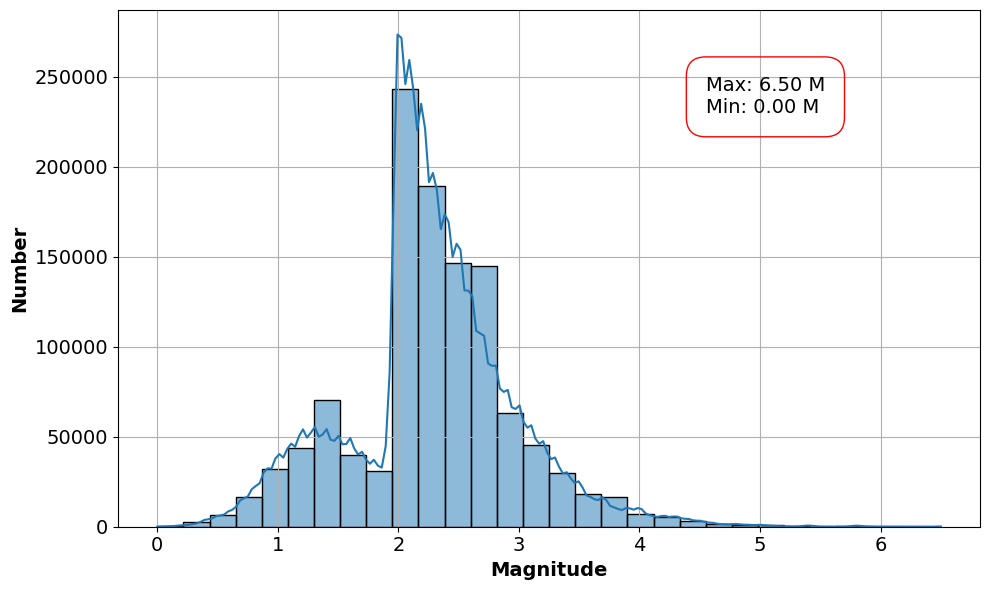

Number of metadata entries now: 1159249


In [ ]:
"""Cell 2: Data Loading and Initial Filtering"""

# Load and access the metadata from the CSV file
metadata = pd.read_csv(metadata_path, low_memory=False)
print(f"Initial number of metadata entries: {len(metadata)}")

# Ensure the 'source_origin_time' column is in datetime format
metadata['source_origin_time'] = pd.to_datetime(metadata['source_origin_time'])

# Sort by source_origin_time to ensure chronological order
metadata = metadata.sort_values(by='source_origin_time')

#================No need to filter by date from September 2018 onwards since we want all data================
# # Filter metadata for dates from September 2018 onwards
# from datetime import datetime, timezone
# start_date = datetime(2018, 9, 1, tzinfo=timezone.utc)
# metadata = metadata[metadata['source_origin_time'] >= start_date]
# print(f"Number of metadata entries from 1st September 2018 to 31st January 2020: {len(metadata)}")
#=============================================================================================================

# Plot the histogram of the earthquake magnitudes before filtering
plt.figure(figsize=(10, 6))
sns.histplot(metadata["source_magnitude"], bins=30, kde=True)
plt.xlabel('Magnitude', fontweight='bold', fontsize=14)
plt.ylabel('Number', fontweight='bold', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)
max_magnitude = metadata["source_magnitude"].max()
min_magnitude = metadata["source_magnitude"].min()
plt.text(0.7*max_magnitude, plt.gca().get_ylim()[1]*0.8,
         f'Max: {max_magnitude:.2f} M\nMin: {min_magnitude:.2f} M',
         bbox=dict(facecolor='none', edgecolor='red', boxstyle='round,pad=1'), fontsize=14)
plt.tight_layout()
plt.show()

print(f"Number of metadata entries now: {len(metadata)}")

Cell 3: Apply Data Filtering Criteria

In [ ]:
"""Cell 3: Apply Data Filtering Criteria"""

import copy

# Create a deep copy of the metadata
filtered_metadata = copy.deepcopy(metadata)

# Set sampling rate
filtered_metadata['trace_sampling_rate_hz'] = 100

# Adjusted filtering for INSTANCE dataset within 30s window
filters = [
    ('path_ep_distance_km <= 110', filtered_metadata.path_ep_distance_km <= 110),
    ('source_magnitude_type == ML', filtered_metadata.source_magnitude_type == 'ML'),
    ('trace_P_arrival_sample.notnull()', filtered_metadata.trace_P_arrival_sample.notnull()),
    ('path_travel_time_P_s.notnull()', filtered_metadata.path_travel_time_P_s.notnull()),
    ('path_travel_time_P_s > 0', filtered_metadata.path_travel_time_P_s > 0),
    ('path_ep_distance_km.notnull()', filtered_metadata.path_ep_distance_km.notnull()),
    ('path_ep_distance_km > 0', filtered_metadata.path_ep_distance_km > 0),
    ('source_depth_km.notnull()', filtered_metadata.source_depth_km.notnull()),
    ('source_magnitude.notnull()', filtered_metadata.source_magnitude.notnull()),
    ('path_backazimuth_deg.notnull()', filtered_metadata.path_backazimuth_deg.notnull()),
    ('path_backazimuth_deg > 0', filtered_metadata.path_backazimuth_deg > 0),
]

# Apply filters one by one and keep track of the data
for desc, filt in filters:
    filtered_metadata = filtered_metadata[filt]
    print(f"After filter '{desc}': {len(filtered_metadata)} entries")

# Ensure at least 30 seconds of data after P-arrival
filtered_metadata = filtered_metadata[filtered_metadata.trace_P_arrival_sample + filtered_metadata.trace_sampling_rate_hz * 30 <= filtered_metadata.trace_npts]
print(f"After ensuring 30s after P arrival: {len(filtered_metadata)} entries")

# Calculate time window statistics
filtered_metadata['window_start'] = filtered_metadata.trace_P_arrival_sample - filtered_metadata.trace_sampling_rate_hz * 5  # 5 seconds before P arrival
filtered_metadata['window_end'] = filtered_metadata.trace_P_arrival_sample + filtered_metadata.trace_sampling_rate_hz * 25  # 25 seconds after P arrival (total 30s window)

# Ensure window start is not negative
filtered_metadata = filtered_metadata[filtered_metadata.window_start >= 0]
print(f"After ensuring non-negative window start: {len(filtered_metadata)} entries")

print(f"\nFinal number of filtered metadata entries: {len(filtered_metadata)}")

After filter 'path_ep_distance_km <= 110': 1010113 entries


/tmp/ipython-input-3586823848.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]


After filter 'source_magnitude_type == ML': 979936 entries


/tmp/ipython-input-3586823848.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]


After filter 'trace_P_arrival_sample.notnull()': 979936 entries


/tmp/ipython-input-3586823848.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]


After filter 'path_travel_time_P_s.notnull()': 979936 entries


/tmp/ipython-input-3586823848.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]


After filter 'path_travel_time_P_s > 0': 979936 entries


/tmp/ipython-input-3586823848.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]


After filter 'path_ep_distance_km.notnull()': 979936 entries


/tmp/ipython-input-3586823848.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]


After filter 'path_ep_distance_km > 0': 979936 entries


/tmp/ipython-input-3586823848.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]


After filter 'source_depth_km.notnull()': 979936 entries


/tmp/ipython-input-3586823848.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]


After filter 'source_magnitude.notnull()': 979936 entries


/tmp/ipython-input-3586823848.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]


After filter 'path_backazimuth_deg.notnull()': 979936 entries


/tmp/ipython-input-3586823848.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]


After filter 'path_backazimuth_deg > 0': 979761 entries
After ensuring 30s after P arrival: 979757 entries
After ensuring non-negative window start: 979755 entries

Final number of filtered metadata entries: 979755


Cell 4: Apply SNR Filter and Multi-Observations

In [ ]:
"""Cell 4: Apply SNR Filter and Multi-Observations"""

# Process SNR
# Check if 'snr_db' column exists, if not, use appropriate column names from INSTANCE dataset
if 'snr_db' in filtered_metadata.columns:
    def string_convertor(dd):
        if isinstance(dd, str):
            dd2 = dd.split()
            SNR = []
            for d in dd2:
                if d not in ['[', ']']:
                    dL = d.split('[')
                    dR = d.split(']')
                    if len(dL) == 2:
                        dig = dL[1]
                    elif len(dR) == 2:
                        dig = dR[0]
                    elif len(dR) == 1 and len(dL) == 1:
                        dig = d
                    try:
                        dig = float(dig)
                    except Exception:
                        dig = None
                    SNR.append(dig)
            return np.mean([x for x in SNR if x is not None])
        else:
            return np.nan

    filtered_metadata['snr_db'] = filtered_metadata.snr_db.apply(string_convertor)
    filtered_metadata = filtered_metadata[filtered_metadata.snr_db >= 20]
else:
    # Use appropriate SNR columns from INSTANCE dataset
    snr_columns = ['trace_E_snr_db', 'trace_N_snr_db', 'trace_Z_snr_db']
    filtered_metadata['avg_snr_db'] = filtered_metadata[snr_columns].mean(axis=1)
    filtered_metadata = filtered_metadata[filtered_metadata.avg_snr_db >= 20]

print(f"Number of records after SNR filtering: {len(filtered_metadata)}")

# Implementing multi-observations with a threshold of >= 400
print("Filtering for multi-observations stations...")
uniq_ins = filtered_metadata.station_code.unique()
labM = []

print("Counting observations per station...")
for station in tqdm(uniq_ins):
    count = sum(filtered_metadata.station_code == station)
    if count >= 400:
        labM.append(station)
        print(f"{station}: {count} observations")

print(f"Number of stations with ≥400 observations: {len(labM)}")

# Save the multi-observations stations list
multi_observations_path = os.path.join(output_dir, "multi_observations.npy")
np.save(multi_observations_path, labM)

# Filter the dataset to include only records from stations with ≥400 observations
df_filtered = filtered_metadata[filtered_metadata.station_code.isin(labM)]
print(f"Number of records after multi-observations filtering: {len(df_filtered)}")

# ADDED: Apply distance filter for lower split
df_filtered = df_filtered[df_filtered.path_ep_distance_km <= 28.07]
print(f"Number of records after distance filtering (≤28.07 km): {len(df_filtered)}")

Number of records after SNR filtering: 407164
Filtering for multi-observations stations...
Counting observations per station...


  1%|          | 3/594 [00:00<00:29, 20.09it/s]

CING: 3055 observations
MURB: 4209 observations
BADI: 1280 observations
GRI: 675 observations


  1%|          | 6/594 [00:00<00:29, 20.15it/s]

RNI2: 834 observations
MIDA: 926 observations


  2%|▏         | 9/594 [00:00<00:28, 20.19it/s]

VAGA: 844 observations


  2%|▏         | 12/594 [00:00<00:28, 20.10it/s]

INTR: 1812 observations
GUAR: 590 observations
FAGN: 3955 observations


  3%|▎         | 15/594 [00:00<00:28, 20.09it/s]

VVLD: 877 observations


  3%|▎         | 18/594 [00:00<00:28, 20.12it/s]

MRLC: 506 observations
FIAM: 4520 observations
MNS: 618 observations


  4%|▎         | 21/594 [00:01<00:28, 20.21it/s]

CERT: 1160 observations
SFI: 1159 observations
FNVD: 671 observations
TIP: 577 observations


  4%|▍         | 24/594 [00:01<00:28, 20.26it/s]

TERO: 11019 observations


  5%|▍         | 27/594 [00:01<00:28, 20.21it/s]

AOI: 427 observations
SACS: 571 observations
CAMP: 3871 observations
ERBM: 414 observations


  6%|▌         | 33/594 [00:01<00:27, 20.11it/s]

MRB1: 400 observations


  6%|▌         | 36/594 [00:01<00:27, 20.08it/s]

SACR: 430 observations
BSSO: 568 observations


  7%|▋         | 39/594 [00:01<00:27, 19.97it/s]

CRE: 464 observations
VLC: 1046 observations


  7%|▋         | 42/594 [00:02<00:27, 20.04it/s]

AQU: 5115 observations


  8%|▊         | 45/594 [00:02<00:27, 20.17it/s]

CEL: 862 observations


  9%|▉         | 54/594 [00:02<00:26, 20.45it/s]

CUC: 1667 observations
GIB: 590 observations


 10%|█         | 60/594 [00:02<00:26, 20.15it/s]

MGR: 712 observations
BDI: 1723 observations


 12%|█▏        | 72/594 [00:03<00:25, 20.24it/s]

VULT: 400 observations
VCEL: 2776 observations
ARVD: 2166 observations
PLAC: 607 observations


 13%|█▎        | 78/594 [00:03<00:25, 20.23it/s]

CDRU: 480 observations
ORI: 401 observations
SERS: 634 observations


 15%|█▍        | 87/594 [00:04<00:25, 20.11it/s]

SCHR: 487 observations
MSAG: 1061 observations
SGRT: 705 observations


 16%|█▌        | 93/594 [00:04<00:24, 20.11it/s]

OFFI: 1646 observations
CERA: 863 observations
SIRI: 1483 observations
MTSN: 499 observations


 17%|█▋        | 99/594 [00:04<00:24, 20.08it/s]

JOPP: 1257 observations
MCEL: 799 observations
GALF: 893 observations


 18%|█▊        | 105/594 [00:05<00:24, 20.06it/s]

BULG: 488 observations
CRMI: 584 observations


 19%|█▊        | 111/594 [00:05<00:23, 20.15it/s]

POFI: 925 observations


 20%|█▉        | 117/594 [00:05<00:23, 20.09it/s]

SSY: 874 observations
MSRU: 844 observations


 21%|██        | 123/594 [00:06<00:23, 19.75it/s]

IVPL: 733 observations
ACER: 482 observations
ASQU: 625 observations


 22%|██▏       | 132/594 [00:06<00:23, 19.97it/s]

HAVL: 400 observations
PIEI: 2442 observations
CAFI: 1011 observations
CDCA: 576 observations
MILZ: 442 observations


 24%|██▎       | 141/594 [00:07<00:22, 20.04it/s]

FSSB: 1475 observations
FDMO: 6690 observations
CESI: 6033 observations
LNSS: 6209 observations


 25%|██▌       | 150/594 [00:07<00:22, 20.06it/s]

MGAB: 2859 observations
PARC: 871 observations
MTCE: 476 observations
LPEL: 1047 observations
MELA: 583 observations


 27%|██▋       | 159/594 [00:07<00:21, 20.03it/s]

CESX: 2443 observations
ASSB: 2222 observations
GUMA: 7527 observations


 29%|██▉       | 171/594 [00:08<00:20, 20.27it/s]

NRCA: 18010 observations
ROVR: 534 observations
MAIM: 408 observations
PZZ: 430 observations


 31%|███       | 183/594 [00:09<00:20, 20.26it/s]

T0104: 1986 observations


 32%|███▏      | 189/594 [00:09<00:19, 20.36it/s]

T0106: 439 observations


 33%|███▎      | 195/594 [00:09<00:19, 20.37it/s]

IACL: 492 observations
MMN: 965 observations
SMA1: 5503 observations


 34%|███▍      | 201/594 [00:09<00:19, 20.20it/s]

SALB: 1246 observations
SNTG: 5397 observations


 37%|███▋      | 222/594 [00:11<00:18, 20.15it/s]

ATVO: 1560 observations
ATPC: 932 observations
ATFO: 1692 observations
ATPI: 1312 observations


 39%|███▉      | 231/594 [00:11<00:18, 20.10it/s]

HLNI: 649 observations
CAR1: 750 observations
IFIL: 591 observations


 40%|███▉      | 237/594 [00:11<00:17, 20.08it/s]

NOV: 756 observations
RM33: 8680 observations


 41%|████      | 243/594 [00:12<00:17, 20.07it/s]

FRON: 1901 observations
MPNC: 798 observations
SSFR: 5856 observations
SLCN: 439 observations
ATTE: 823 observations


 43%|████▎     | 255/594 [00:12<00:16, 20.09it/s]

MCSR: 636 observations
PTQR: 400 observations
MUCR: 802 observations
CPGN: 593 observations


 44%|████▍     | 261/594 [00:12<00:16, 20.22it/s]

ATCC: 4133 observations
POPM: 537 observations


 45%|████▌     | 270/594 [00:13<00:16, 20.09it/s]

MPAG: 1213 observations
CET2: 667 observations


 47%|████▋     | 279/594 [00:13<00:15, 20.07it/s]

NARO: 760 observations
SSP9: 609 observations


 48%|████▊     | 284/594 [00:14<00:15, 19.86it/s]

ATMI: 998 observations
MDAR: 913 observations
ARRO: 2425 observations
SEF1: 1236 observations


 49%|████▊     | 289/594 [00:14<00:15, 19.94it/s]

FEMA: 4320 observations


 53%|█████▎    | 312/594 [00:15<00:13, 20.20it/s]

COR1: 563 observations


 54%|█████▍    | 321/594 [00:15<00:13, 20.29it/s]

FIU1: 504 observations
MOMA: 2665 observations


 56%|█████▌    | 330/594 [00:16<00:13, 20.23it/s]

EL6: 4719 observations
PE3: 695 observations
CSP1: 6475 observations


 57%|█████▋    | 336/594 [00:16<00:12, 20.21it/s]

T0702: 624 observations


 58%|█████▊    | 345/594 [00:17<00:12, 20.20it/s]

AIO: 588 observations
FOSV: 2719 observations


 60%|█████▉    | 354/594 [00:17<00:11, 20.13it/s]

GAG1: 533 observations


 61%|██████    | 360/594 [00:17<00:11, 20.01it/s]

RUFI: 853 observations
MTCR: 955 observations


 61%|██████▏   | 365/594 [00:18<00:11, 19.85it/s]

SEI: 432 observations
CARD: 445 observations
ATLO: 575 observations


 63%|██████▎   | 377/594 [00:18<00:10, 20.05it/s]

OSSC: 420 observations
MNTP: 704 observations


 65%|██████▌   | 389/594 [00:19<00:10, 20.17it/s]

PP3: 598 observations


 70%|██████▉   | 413/594 [00:20<00:08, 20.13it/s]

T0110: 798 observations
ATSC: 595 observations
GIGS: 907 observations


 78%|███████▊  | 464/594 [00:23<00:06, 20.31it/s]

MC2: 5765 observations
T1211: 5386 observations
T1243: 5407 observations
MMO1: 4343 observations
T1212: 5609 observations
T1241: 4078 observations


 79%|███████▉  | 470/594 [00:23<00:06, 20.42it/s]

T1213: 2856 observations
T1242: 1316 observations
T1214: 4705 observations
T1201: 1900 observations
T1202: 2207 observations
T1215: 8736 observations
T1204: 2642 observations
T1218: 8178 observations


 80%|████████  | 476/594 [00:23<00:05, 20.36it/s]

T1244: 3933 observations
T1216: 11068 observations


 82%|████████▏ | 485/594 [00:24<00:05, 20.34it/s]

T1246: 1139 observations
T1247: 1889 observations
T1299: 6265 observations
AM05: 2282 observations
T1217: 6178 observations
T1245: 6694 observations


 83%|████████▎ | 491/594 [00:24<00:05, 20.40it/s]

T1256: 3801 observations
T1219: 7474 observations
T1220: 4335 observations
T1221: 4449 observations


 84%|████████▎ | 497/594 [00:24<00:04, 20.29it/s]

T1222: 1107 observations


 86%|████████▌ | 509/594 [00:25<00:04, 20.19it/s]

MTRA: 1422 observations


 87%|████████▋ | 518/594 [00:25<00:03, 19.90it/s]

MF5: 1011 observations


 88%|████████▊ | 525/594 [00:26<00:03, 19.97it/s]

PF6: 904 observations


 91%|█████████ | 540/594 [00:26<00:02, 20.02it/s]

MML1: 764 observations


 93%|█████████▎| 555/594 [00:27<00:01, 20.19it/s]

GAVE: 468 observations


100%|██████████| 594/594 [00:29<00:00, 20.14it/s]


Number of stations with ≥400 observations: 169
Number of records after multi-observations filtering: 362234
Number of records after distance filtering (≤28.07 km): 181093


Plot the histogram of the earthquake magnitudes after filtering

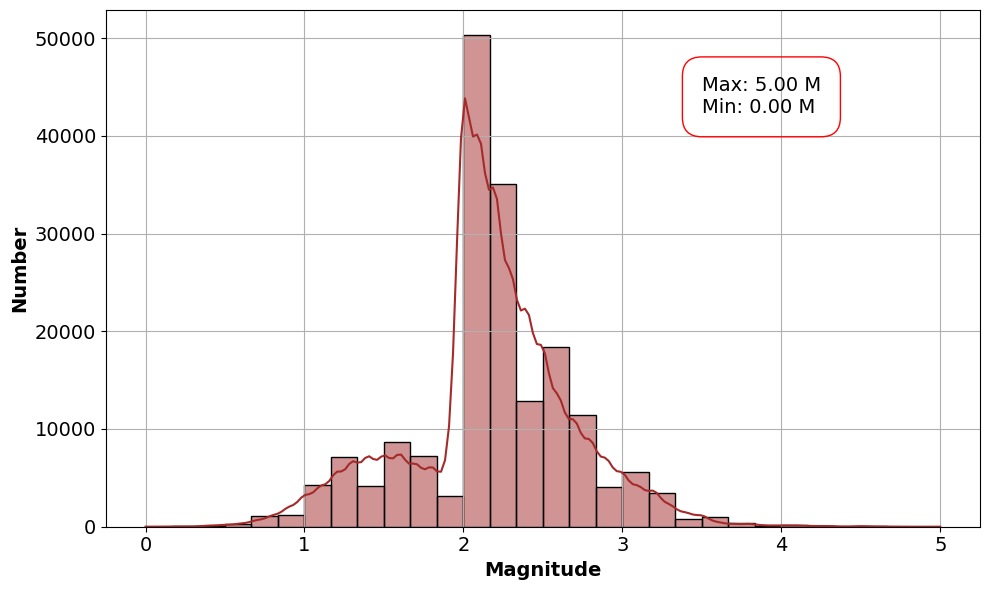

In [ ]:
# Plot the histogram of the earthquake magnitudes after filtering
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered["source_magnitude"], bins=30, kde=True, color='brown')
plt.xlabel('Magnitude', fontweight='bold', fontsize=14)
plt.ylabel('Number', fontweight='bold', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)
max_magnitude = df_filtered["source_magnitude"].max()
min_magnitude = df_filtered["source_magnitude"].min()
plt.text(0.7*max_magnitude, plt.gca().get_ylim()[1]*0.8,
         f'Max: {max_magnitude:.2f} M\nMin: {min_magnitude:.2f} M',
         bbox=dict(facecolor='none', edgecolor='red', boxstyle='round,pad=1'), fontsize=14)
plt.tight_layout()
plt.show()

Plot the histogram of the earthquake epicenter distance after filtering

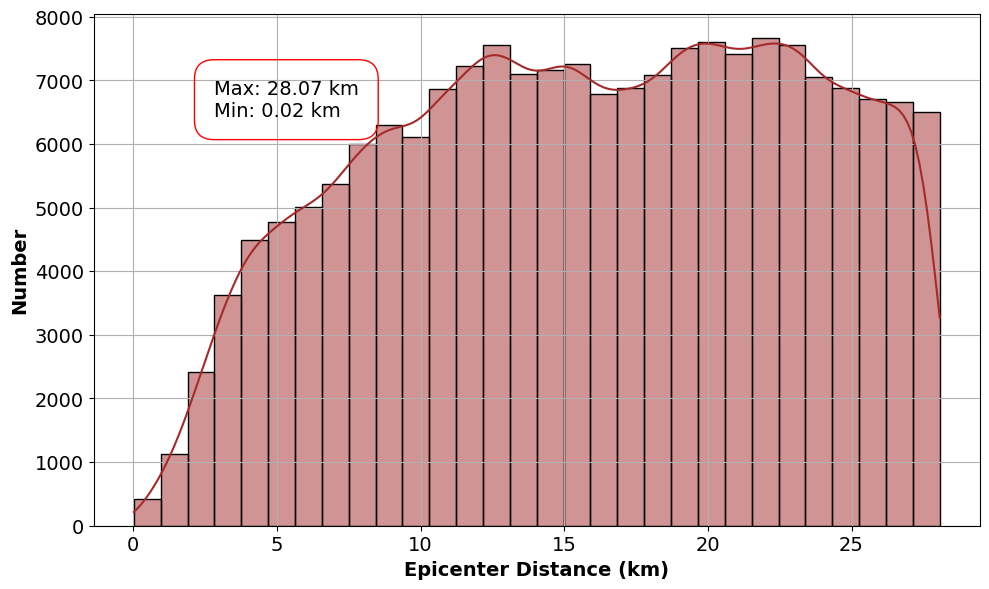

In [ ]:
# Plot the histogram of the earthquake epicenter distance (< 28.07 km) after filtering
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered["path_ep_distance_km"], bins=30, kde=True, color='brown')
plt.xlabel('Epicenter Distance (km)', fontweight='bold', fontsize=14)
plt.ylabel('Number', fontweight='bold', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)
max_distance = df_filtered["path_ep_distance_km"].max()
min_distance = df_filtered["path_ep_distance_km"].min()
plt.text(0.1*max_distance, plt.gca().get_ylim()[1]*0.8,
         f'Max: {max_distance:.2f} km\nMin: {min_distance:.2f} km',
         bbox=dict(facecolor='none', edgecolor='red', boxstyle='round,pad=1'), fontsize=14)
plt.tight_layout()
plt.show()

Cell 5: Group Seismograms by Events (KEY EVENT-BASED LOGIC)

Grouping seismograms by source event ID...
Number of unique earthquake events: 28966
Average seismograms per event: 6.25

Distribution statistics of seismograms per event:
Minimum: 1 seismograms per event
Maximum: 39 seismograms per event

Detailed frequency distribution:
Number of events with 1 seismogram: 6870
Number of events with 2 seismograms: 4894
Number of events with 3 seismograms: 3217
Number of events with 4 seismograms: 2318
Number of events with 5 seismograms: 1754
Number of events with 6 seismograms: 1162
Number of events with 7 seismograms: 805
Number of events with 8 seismograms: 651
Number of events with 9 seismograms: 615
Number of events with 10 seismograms: 588
Number of events with 11 seismograms: 618
Number of events with 12 seismograms: 625
Number of events with 13 seismograms: 596
Number of events with 14 seismograms: 513
Number of events with 15 seismograms: 446
Number of events with 16 seismograms: 389
Number of events with 17 seismograms: 364
Number of events 

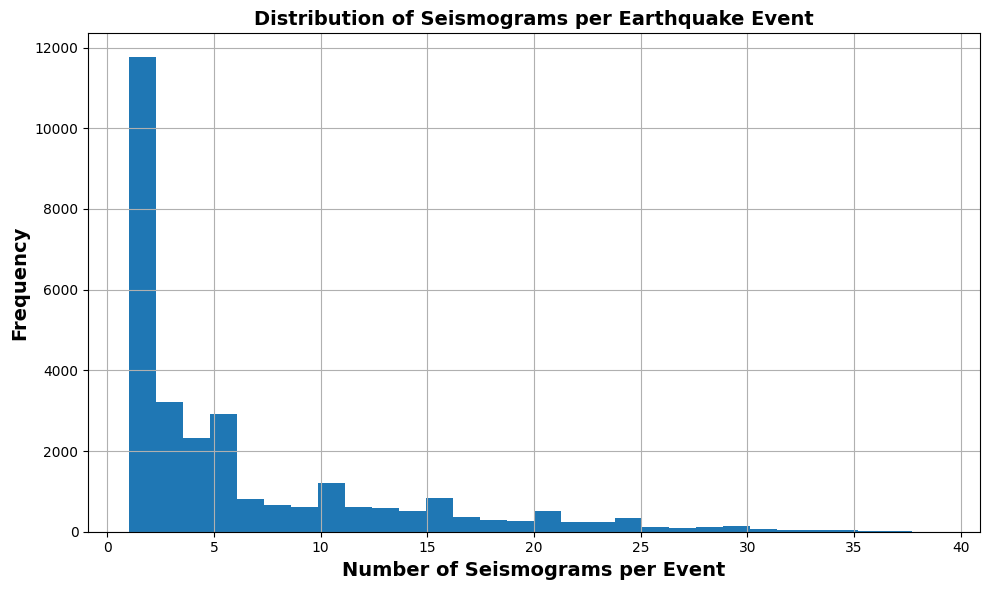

In [ ]:
"""Cell 5: Group Seismograms by Events (KEY ADAPTATION)"""

# Group seismograms by their source event ID (THIS IS THE KEY EVENT-BASED LOGIC)
print("Grouping seismograms by source event ID...")
event_to_seismograms = defaultdict(list)
seismogram_to_event = {}
event_metadata = {}

for index, row in df_filtered.iterrows():
    # Use source_id as the event identifier (adapt this if INSTANCE uses a different field)
    event_id = row['source_id'] if 'source_id' in row else row['source_event_id']  # Adapt field name as needed
    seismogram_id = row['trace_name']

    event_to_seismograms[event_id].append(seismogram_id)
    seismogram_to_event[seismogram_id] = event_id

    # Store metadata for each event (only once per event)
    if event_id not in event_metadata:
        event_metadata[event_id] = {
            'magnitude': row['source_magnitude'],
            'latitude': row['source_latitude_deg'], # Use correct column name for latitude: source_latitude_deg
            'longitude': row['source_longitude_deg'], # Use correct column name for longitude: source_longitude_deg
            'depth': row['source_depth_km'],
            'origin_time': row['source_origin_time']
        }

print(f"Number of unique earthquake events: {len(event_to_seismograms)}")
print(f"Average seismograms per event: {len(df_filtered) / len(event_to_seismograms):.2f}")

# Calculate the frequency of events with each number of seismograms
seismograms_per_event = [len(seismograms) for seismograms in event_to_seismograms.values()]

# Print summary statistics
print("\nDistribution statistics of seismograms per event:")
print(f"Minimum: {min(seismograms_per_event)} seismograms per event")
print(f"Maximum: {max(seismograms_per_event)} seismograms per event")

# Count frequency of each number of seismograms
counts = {}
for count in seismograms_per_event:
    counts[count] = counts.get(count, 0) + 1

# Output the counts
print("\nDetailed frequency distribution:")
for num_seismograms in range(1, min(21, max(seismograms_per_event) + 1)):  # Show up to 20 for readability
    num_events = counts.get(num_seismograms, 0)
    if num_events > 0:  # Only print non-zero counts to save space
        print(f"Number of events with {num_seismograms} seismogram{'s' if num_seismograms > 1 else ''}: {num_events}")

# Analyze the distribution of seismograms per event
seismograms_per_event = [len(seismograms) for seismograms in event_to_seismograms.values()]
plt.figure(figsize=(10, 6))
plt.hist(seismograms_per_event, bins=30)
plt.xlabel('Number of Seismograms per Event', fontweight='bold', fontsize=14)
plt.ylabel('Frequency', fontweight='bold', fontsize=14)
plt.title('Distribution of Seismograms per Earthquake Event', fontweight='bold', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

Cell 6: Check Available Seismograms and Load Data

In [ ]:
"""Cell 6: Check Available Seismograms and Load Data"""

# Check which seismograms exist in the HDF5 file
print("Checking available seismograms in HDF5 file...")

def explore_hdf5_structure(file_path):
    """Explore the HDF5 structure to understand data organization"""
    with h5py.File(file_path, 'r') as f:
        print("HDF5 structure:")
        f.visititems(lambda name, obj: print(f"  {name}: {type(obj)}"))

explore_hdf5_structure(hdf5_path)

# Get list of valid seismograms from the filtered metadata
valid_seismogram_ids = df_filtered['trace_name'].tolist()
print(f"Number of seismograms to load: {len(valid_seismogram_ids)}")

# Rebuild the event-to-seismograms mapping with only valid seismograms
valid_event_to_seismograms = defaultdict(list)
for seis_id in valid_seismogram_ids:
    event_id = seismogram_to_event[seis_id]
    valid_event_to_seismograms[event_id].append(seis_id)

# Remove events that have no valid seismograms left
valid_event_to_seismograms = {k: v for k, v in valid_event_to_seismograms.items() if len(v) > 0}
print(f"Number of events with valid seismograms: {len(valid_event_to_seismograms)}")

# Function to load seismogram data from HDF5 file (adapted for INSTANCE)
def load_seismogram_instance(hdf5_path, seismogram_id, metadata_row):
    """
    Load a single seismogram from the INSTANCE HDF5 file

    Args:
        hdf5_path: Path to the HDF5 file
        seismogram_id: ID of the seismogram to load (trace_name)
        metadata_row: Row from metadata containing trace information

    Returns:
        Tuple of (data, magnitude) or (None, None) if seismogram not found

    Notes:
        - Data is a 30-second window: 5s before P-arrival and 25s after
        - Resampled to 100Hz if necessary
    """
    try:
        with h5py.File(hdf5_path, 'r') as hdf:
            # Parse the trace name to get bucket and trace index
            bucket, trace_info = seismogram_id.split('$')
            trace_index = int(trace_info.split(',')[0])

            # Retrieve waveform data
            waveform = np.array(hdf['data'][bucket][trace_index])

            sampling_rate = metadata_row['trace_sampling_rate_hz']
            spt = int(metadata_row['trace_P_arrival_sample'])

            # Adjust window size based on sampling rate
            window_samples = int(30 * sampling_rate)  # 30 seconds window
            start = max(0, spt - int(5 * sampling_rate))  # 5 seconds before P arrival
            end = start + window_samples

            if start >= waveform.shape[1] or end > waveform.shape[1]:
                print(f"Skipping event {seismogram_id}: Invalid window")
                return None, None

            dshort = waveform[:, start:end]

            # Ensure the shape is correct
            if dshort.shape[1] != window_samples:
                print(f"Skipping event {seismogram_id}: Incorrect window size")
                return None, None

            # Resample to 100 Hz if necessary
            if sampling_rate != 100:
                dshort = scipy.signal.resample(dshort, 3000, axis=1)

            mag = round(float(metadata_row['source_magnitude']), 2)

            return dshort, mag

    except Exception as e:
        print(f"Error processing event {seismogram_id}: {e}")
        return None, None

Checking available seismograms in HDF5 file...
HDF5 structure:
  data: <class 'h5py._hl.group.Group'>
  data/bucket0: <class 'h5py._hl.dataset.Dataset'>
  data/bucket1: <class 'h5py._hl.dataset.Dataset'>
  data/bucket10: <class 'h5py._hl.dataset.Dataset'>
  data/bucket100: <class 'h5py._hl.dataset.Dataset'>
  data/bucket1000: <class 'h5py._hl.dataset.Dataset'>
  data/bucket1001: <class 'h5py._hl.dataset.Dataset'>
  data/bucket1002: <class 'h5py._hl.dataset.Dataset'>
  data/bucket1003: <class 'h5py._hl.dataset.Dataset'>
  data/bucket1004: <class 'h5py._hl.dataset.Dataset'>
  data/bucket1005: <class 'h5py._hl.dataset.Dataset'>
  data/bucket1006: <class 'h5py._hl.dataset.Dataset'>
  data/bucket1007: <class 'h5py._hl.dataset.Dataset'>
  data/bucket1008: <class 'h5py._hl.dataset.Dataset'>
  data/bucket1009: <class 'h5py._hl.dataset.Dataset'>
  data/bucket101: <class 'h5py._hl.dataset.Dataset'>
  data/bucket1010: <class 'h5py._hl.dataset.Dataset'>
  data/bucket1011: <class 'h5py._hl.dataset.

Cell 7: Load All Valid Seismograms and Create Event Data

In [ ]:
"""Cell 7: Load All Valid Seismograms and Create Event Data"""

# Load all valid seismograms
print("Loading all valid seismograms...")
all_data = []
all_labels = []
all_event_ids = []  # To track which event each seismogram belongs to
all_seismogram_ids = []  # To track the original seismogram ID

# Event data dict to store waveforms by event
event_waveform_data = {}

# Create a lookup dictionary for metadata rows
metadata_lookup = {row['trace_name']: row for _, row in df_filtered.iterrows()}

for event_id, seismogram_ids in tqdm(valid_event_to_seismograms.items(), desc="Loading events"):
    event_waveforms = []

    for seis_id in seismogram_ids:
        if seis_id not in metadata_lookup:
            continue

        metadata_row = metadata_lookup[seis_id]
        data, label = load_seismogram_instance(hdf5_path, seis_id, metadata_row)

        if data is None:
            continue

        all_data.append(data)
        all_labels.append(label)
        all_event_ids.append(event_id)
        all_seismogram_ids.append(seis_id)

        # Store for event visualization
        event_waveforms.append({
            'data': data,
            'magnitude': label,
            'seismogram_id': seis_id
        })

    if event_waveforms:  # Only store events that have valid waveforms
        event_waveform_data[event_id] = event_waveforms

# Convert lists to numpy arrays
all_data = np.array(all_data)
all_labels = np.array(all_labels)
all_event_ids = np.array(all_event_ids)
all_seismogram_ids = np.array(all_seismogram_ids)

print(f"Final dataset: {len(all_data)} seismograms from {len(np.unique(all_event_ids))} events")
print(f"Data shape: {all_data.shape}, Labels shape: {all_labels.shape}")

# Save the mapping between seismogram indices and their IDs
with open(os.path.join(output_dir, 'seismogram_indices.pkl'), 'wb') as f:
    pickle.dump({
        'seismogram_ids': all_seismogram_ids,
        'event_ids': all_event_ids
    }, f)

Loading all valid seismograms...


Loading events: 100%|██████████| 28966/28966 [12:31<00:00, 38.54it/s] 


Final dataset: 181093 seismograms from 28966 events
Data shape: (181093, 3, 3000), Labels shape: (181093,)


Cell 8: Visualize Example Events


Visualizing example events with multiple seismograms:
Example 1: Event 8978771 with 39 seismograms


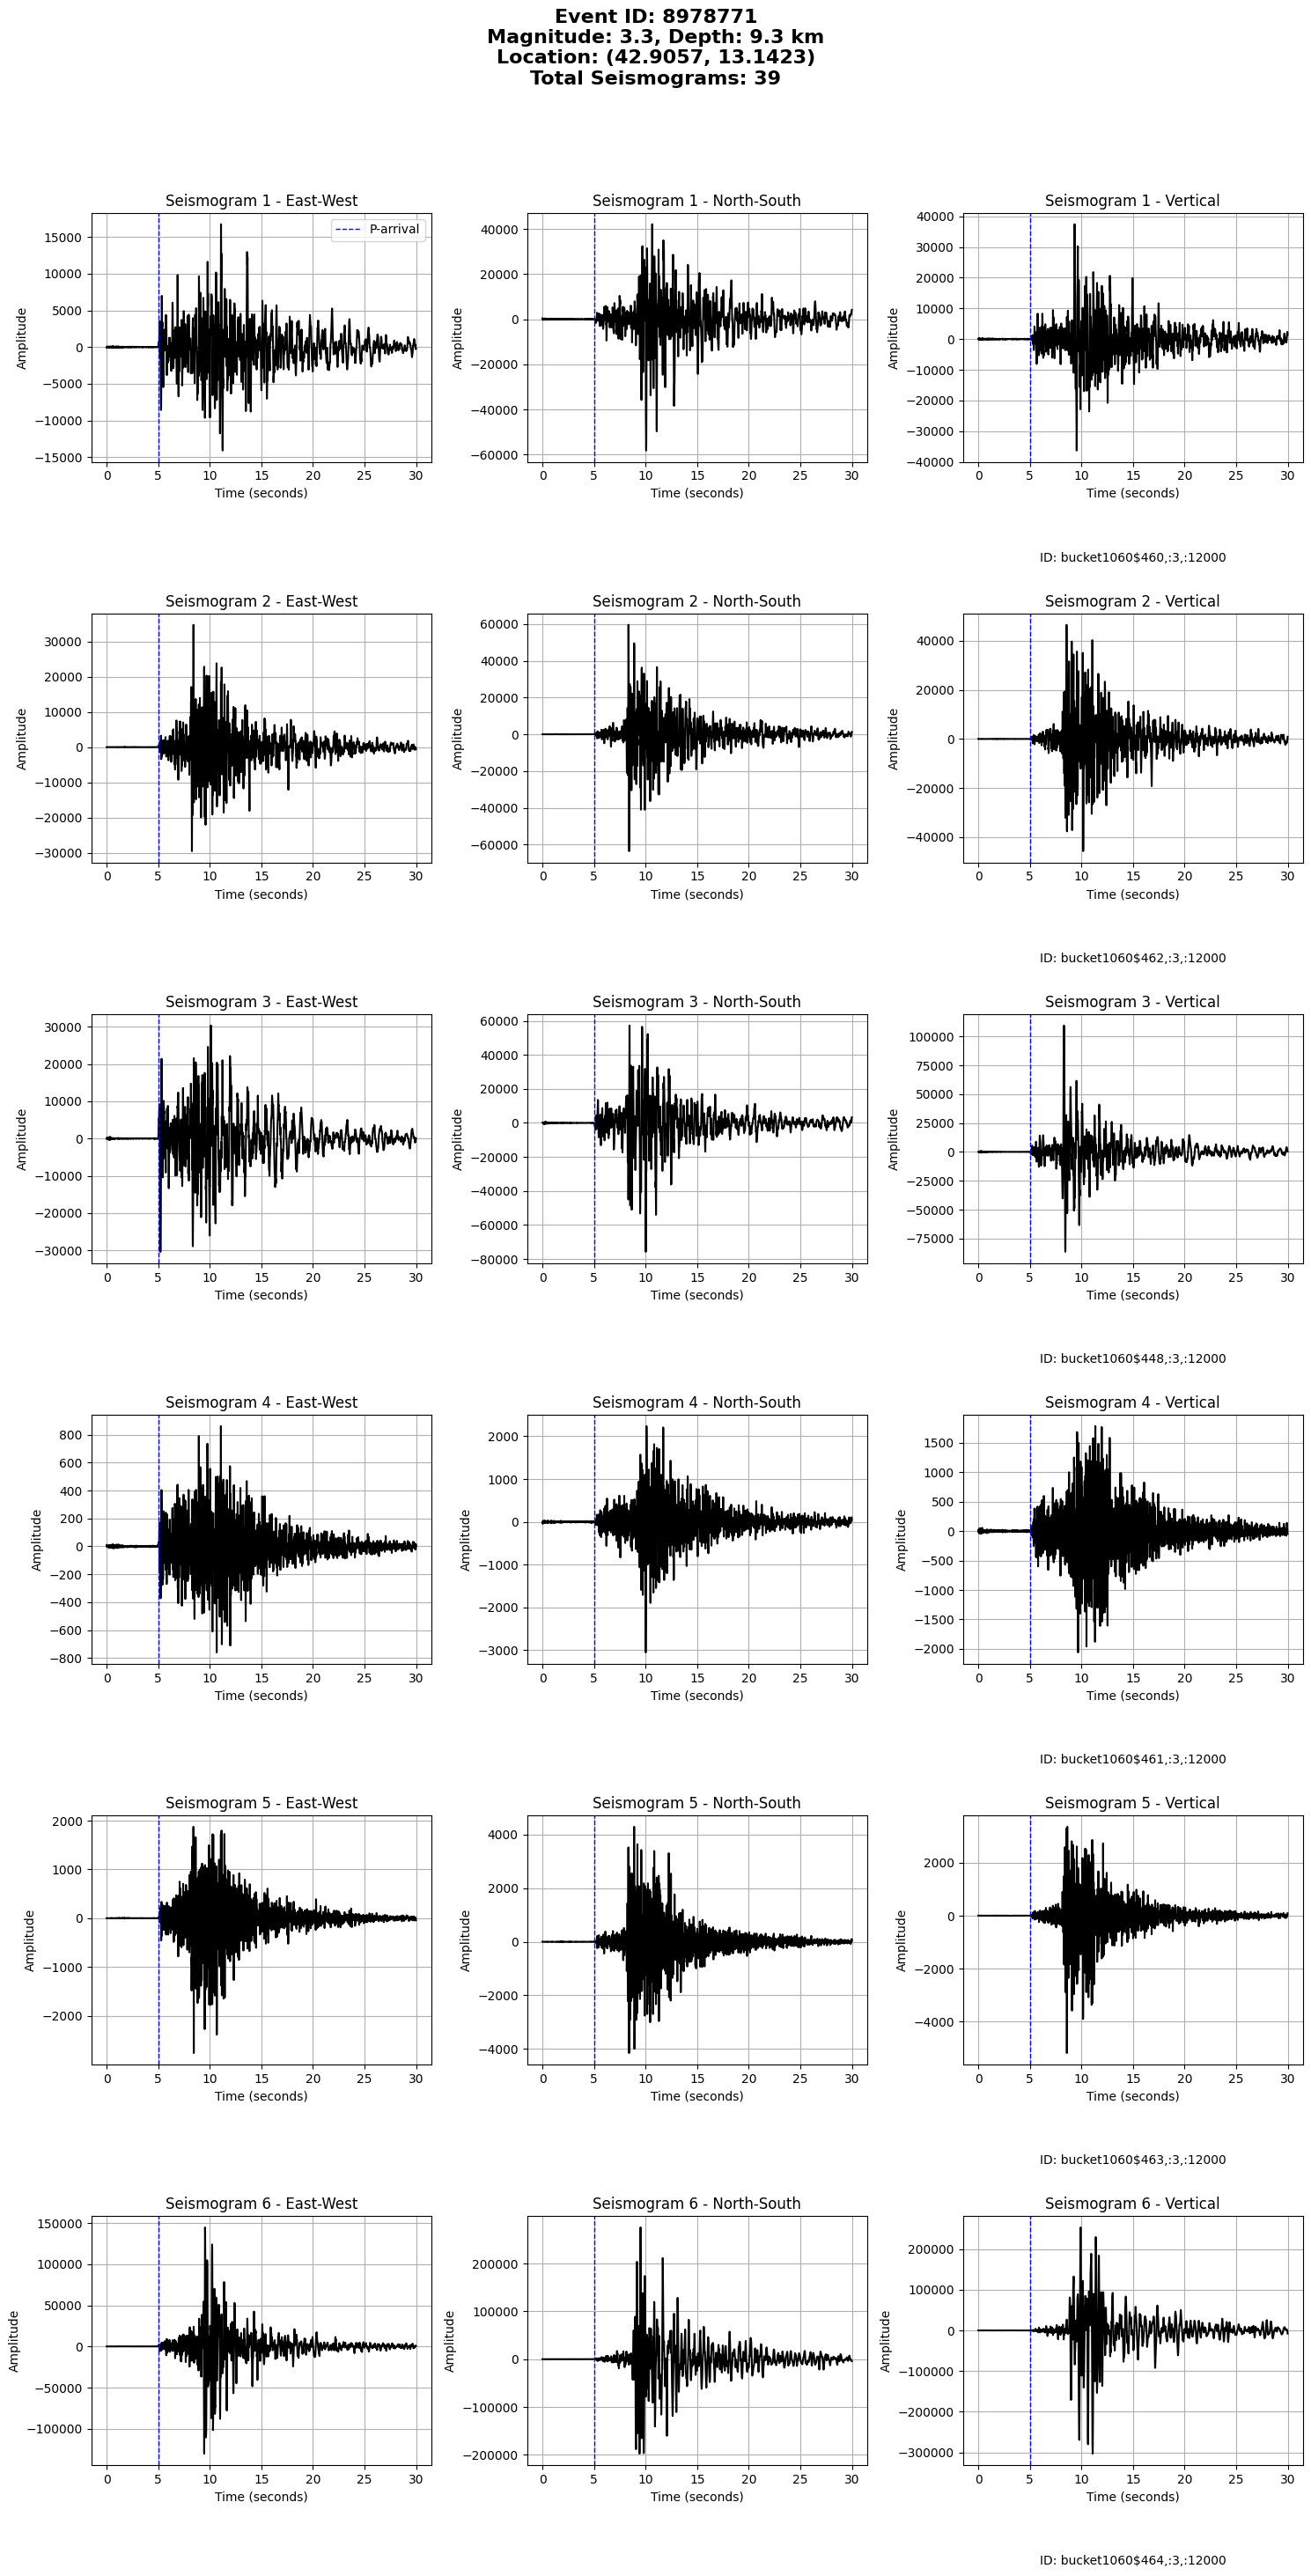

Example 2: Event 8843681 with 37 seismograms


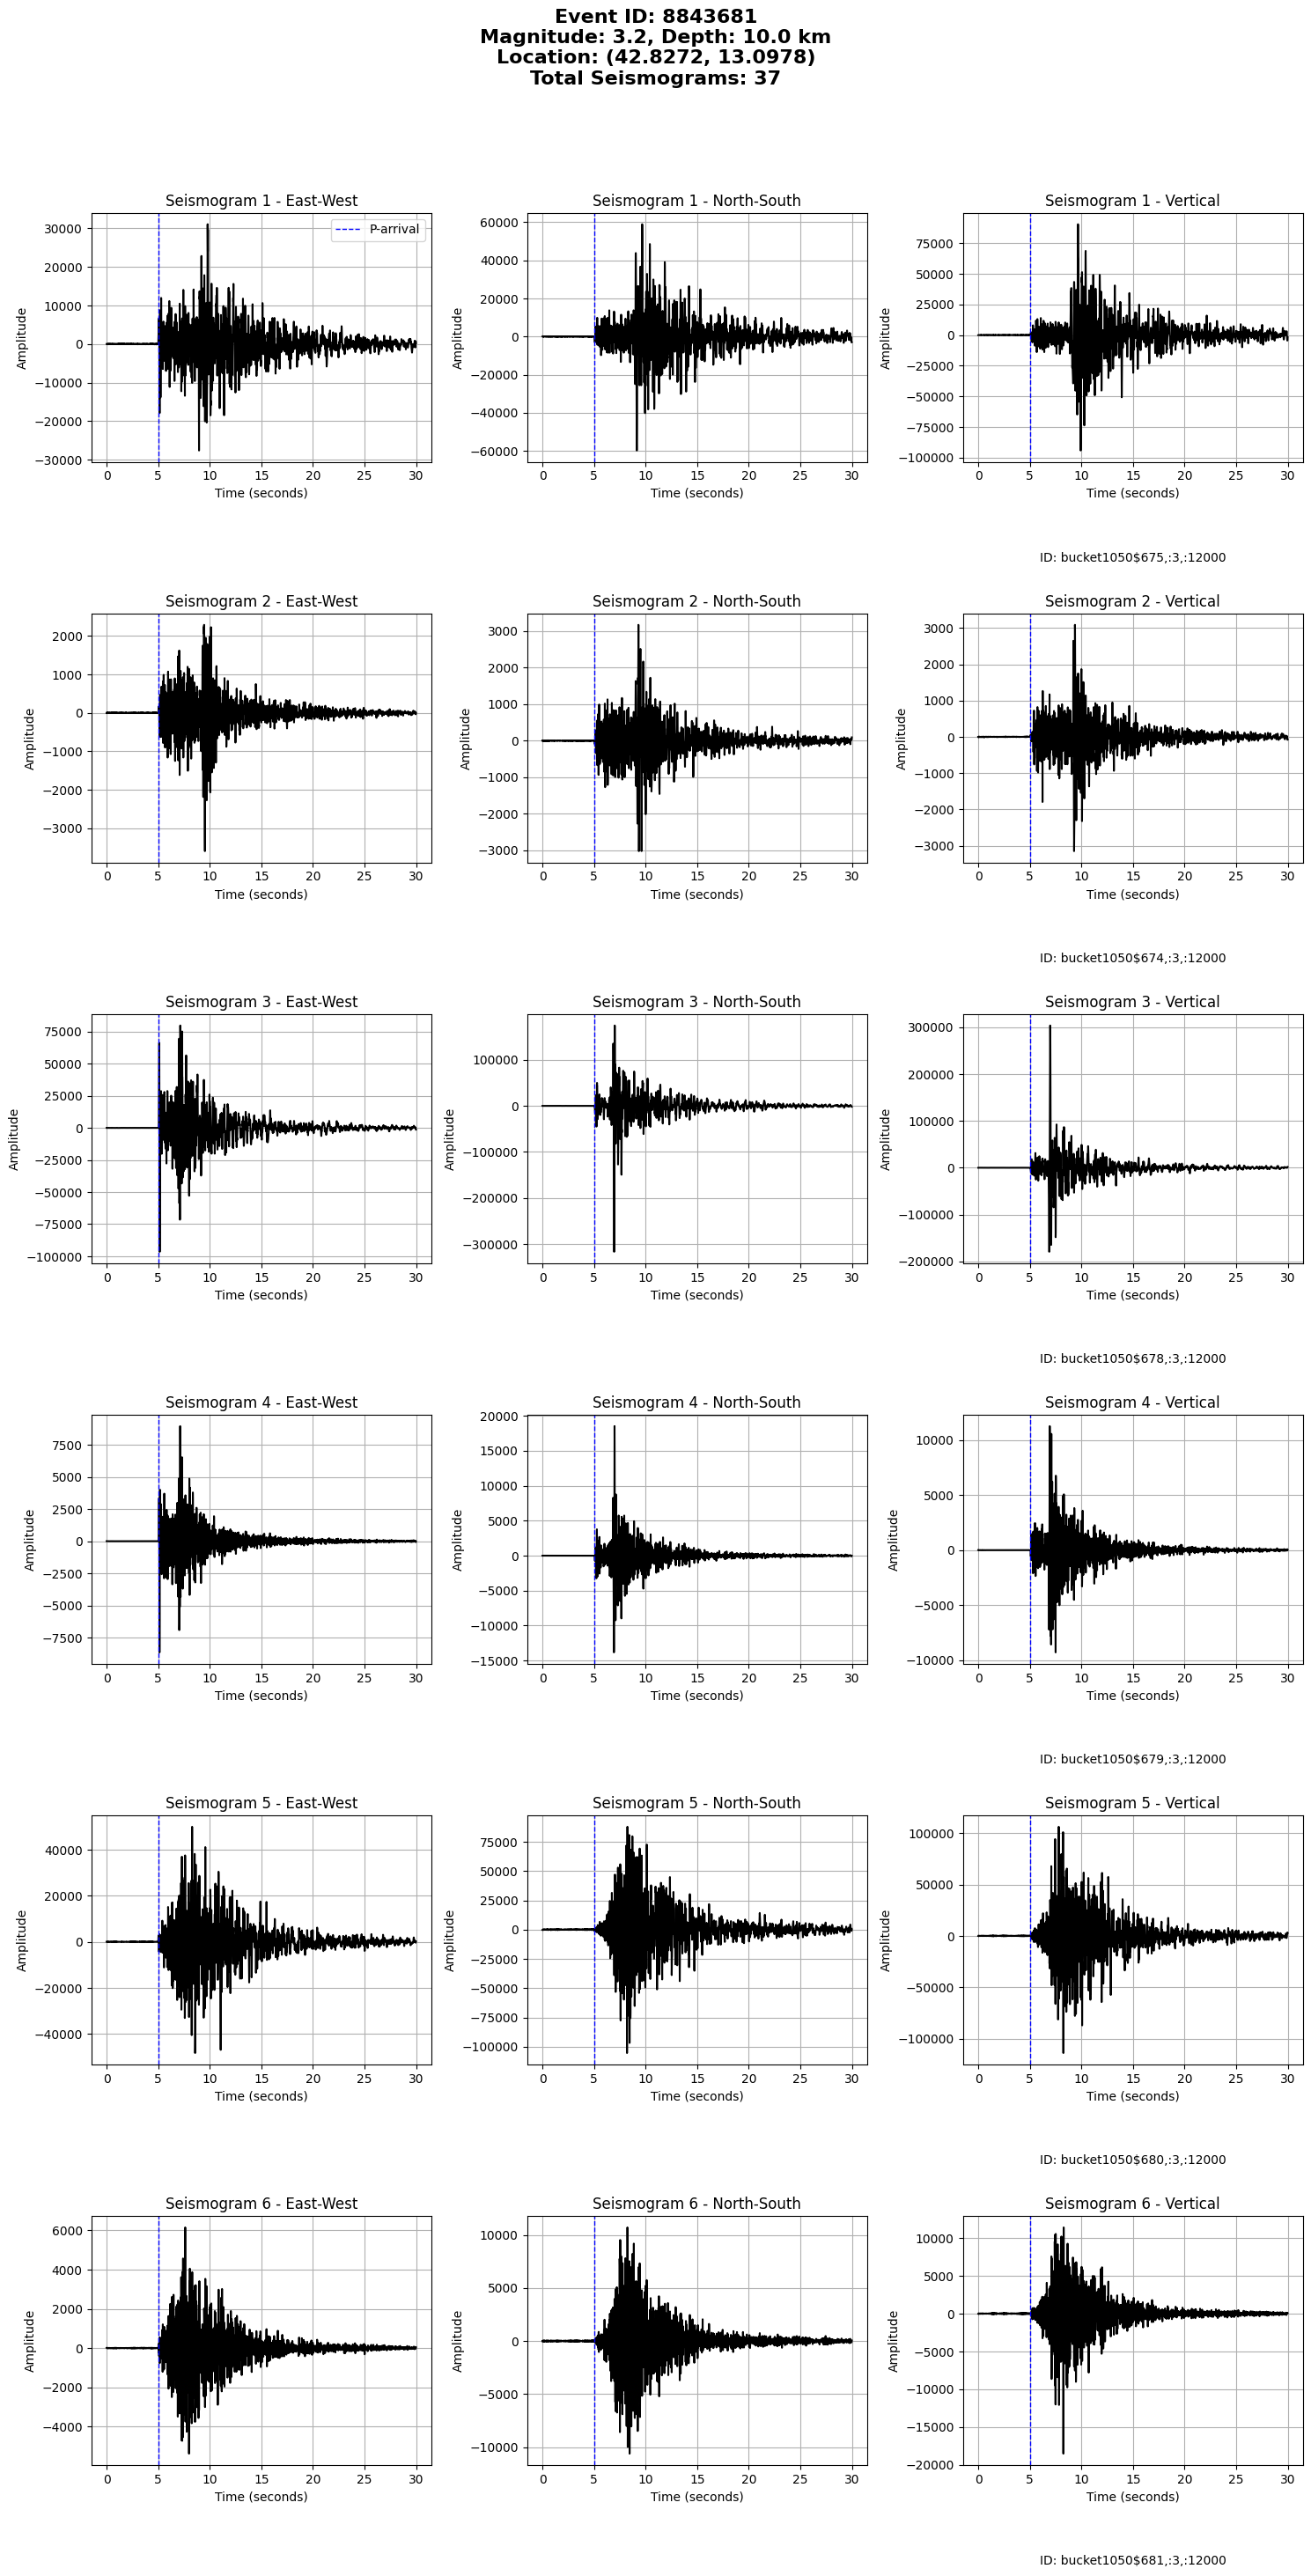

Example 3: Event 9008551 with 37 seismograms


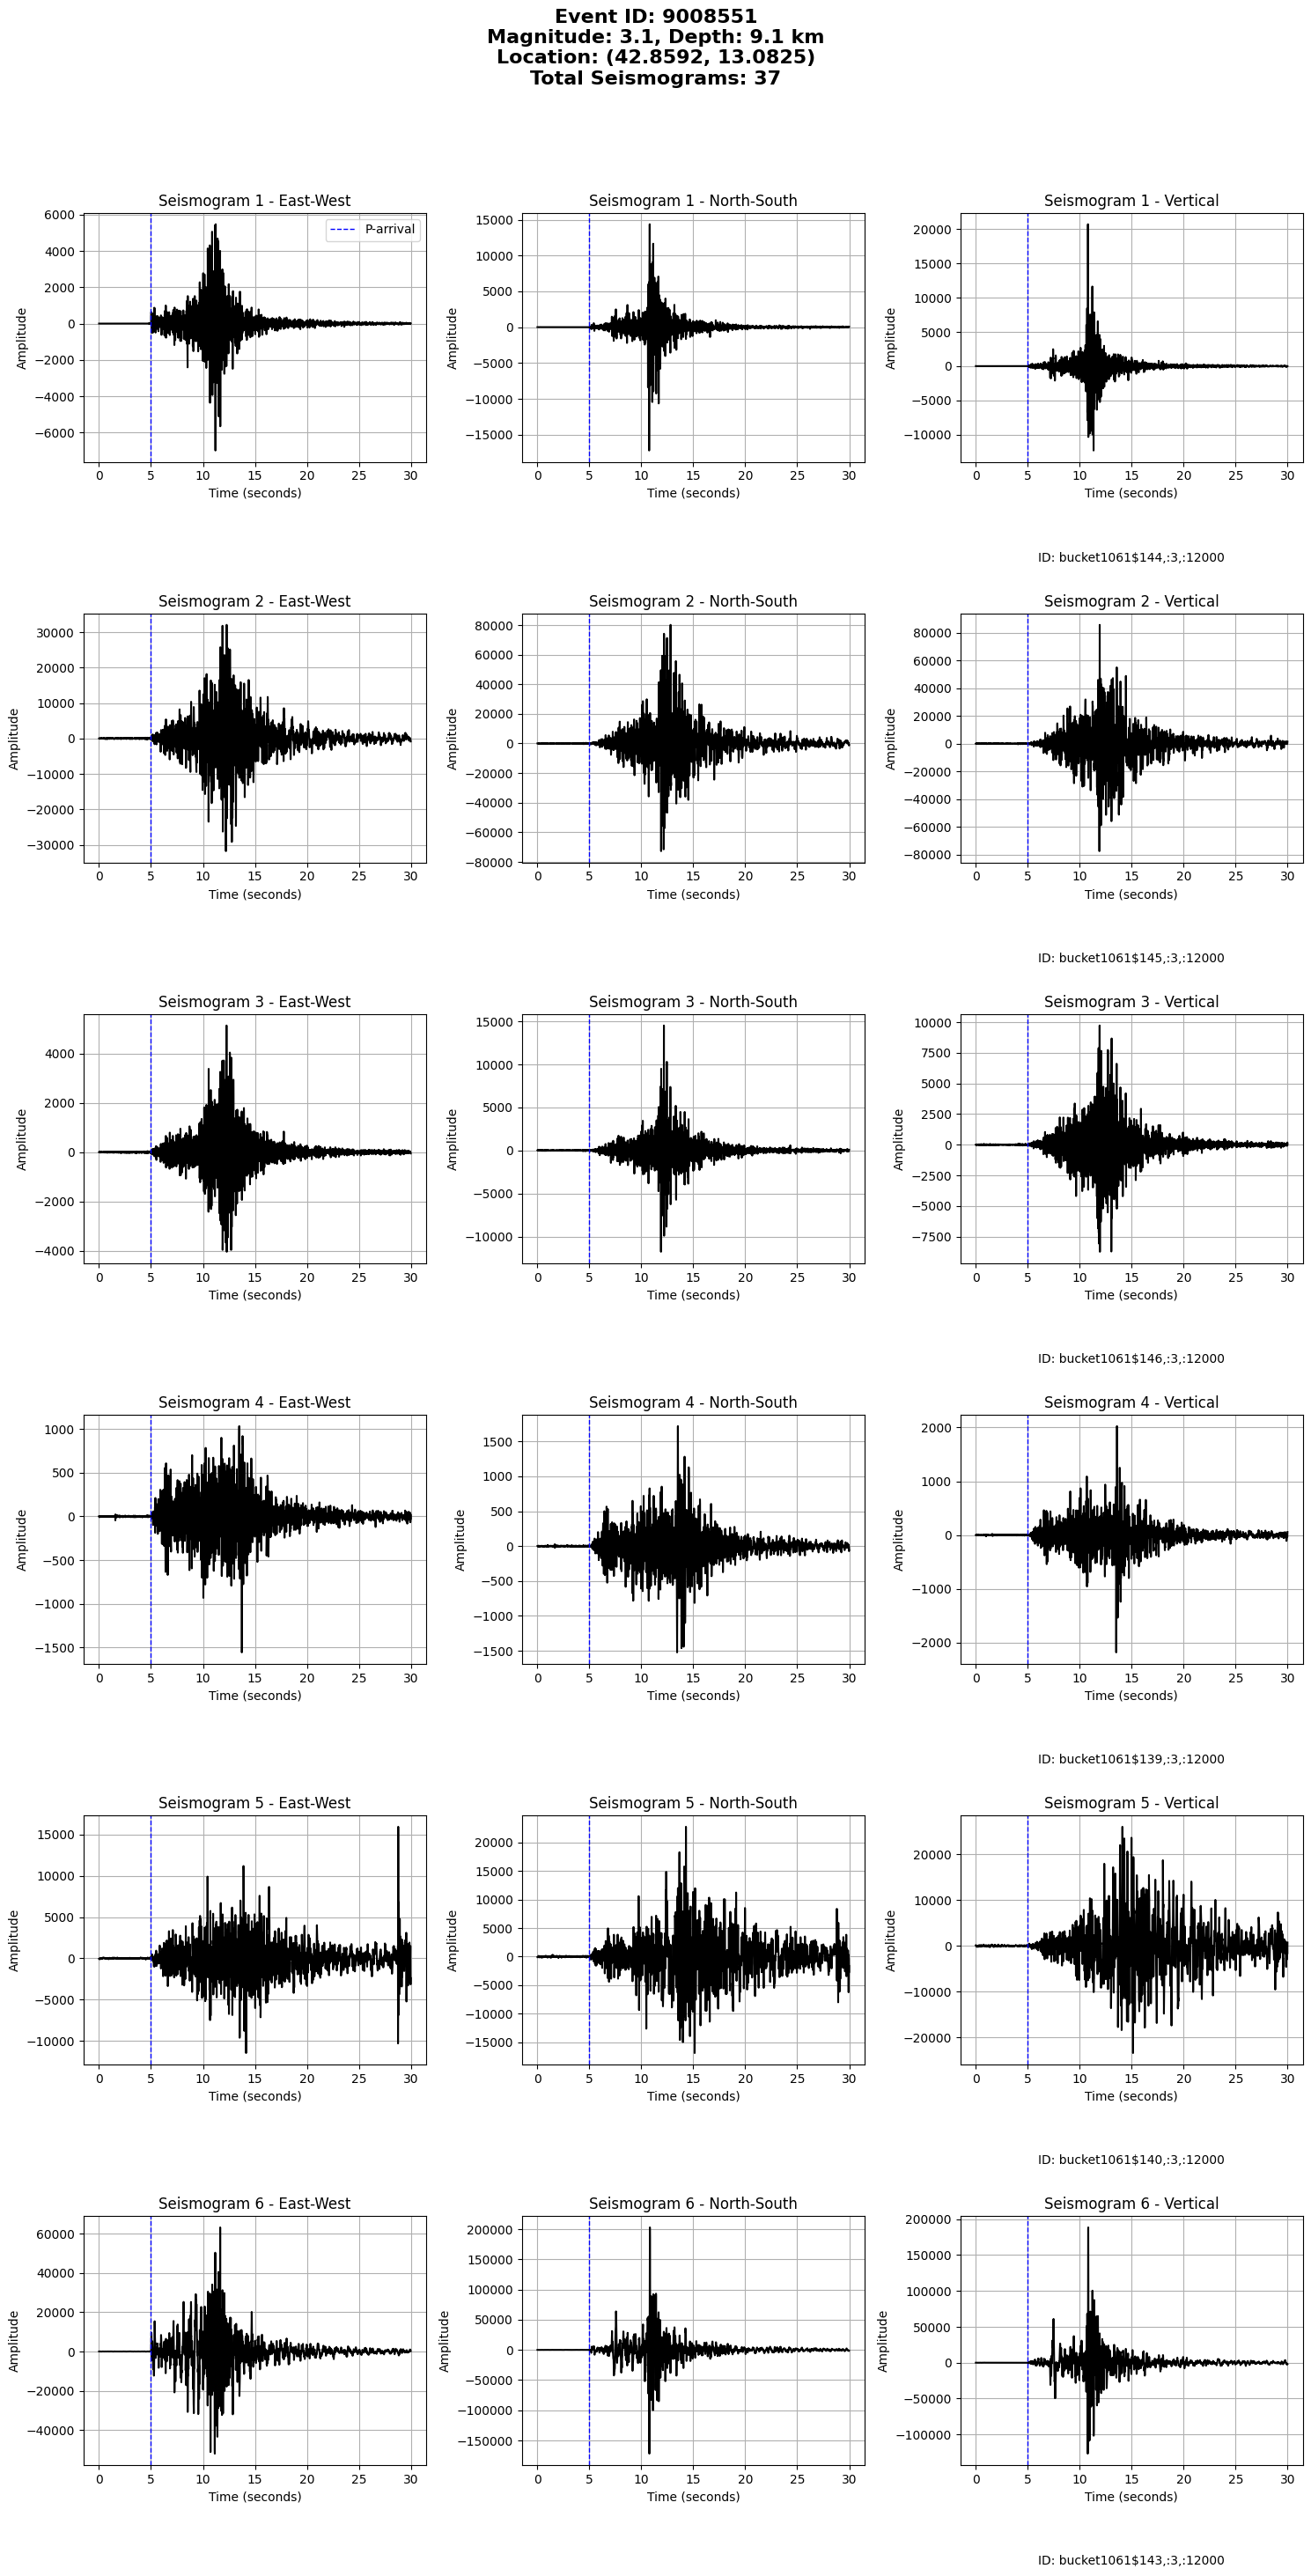

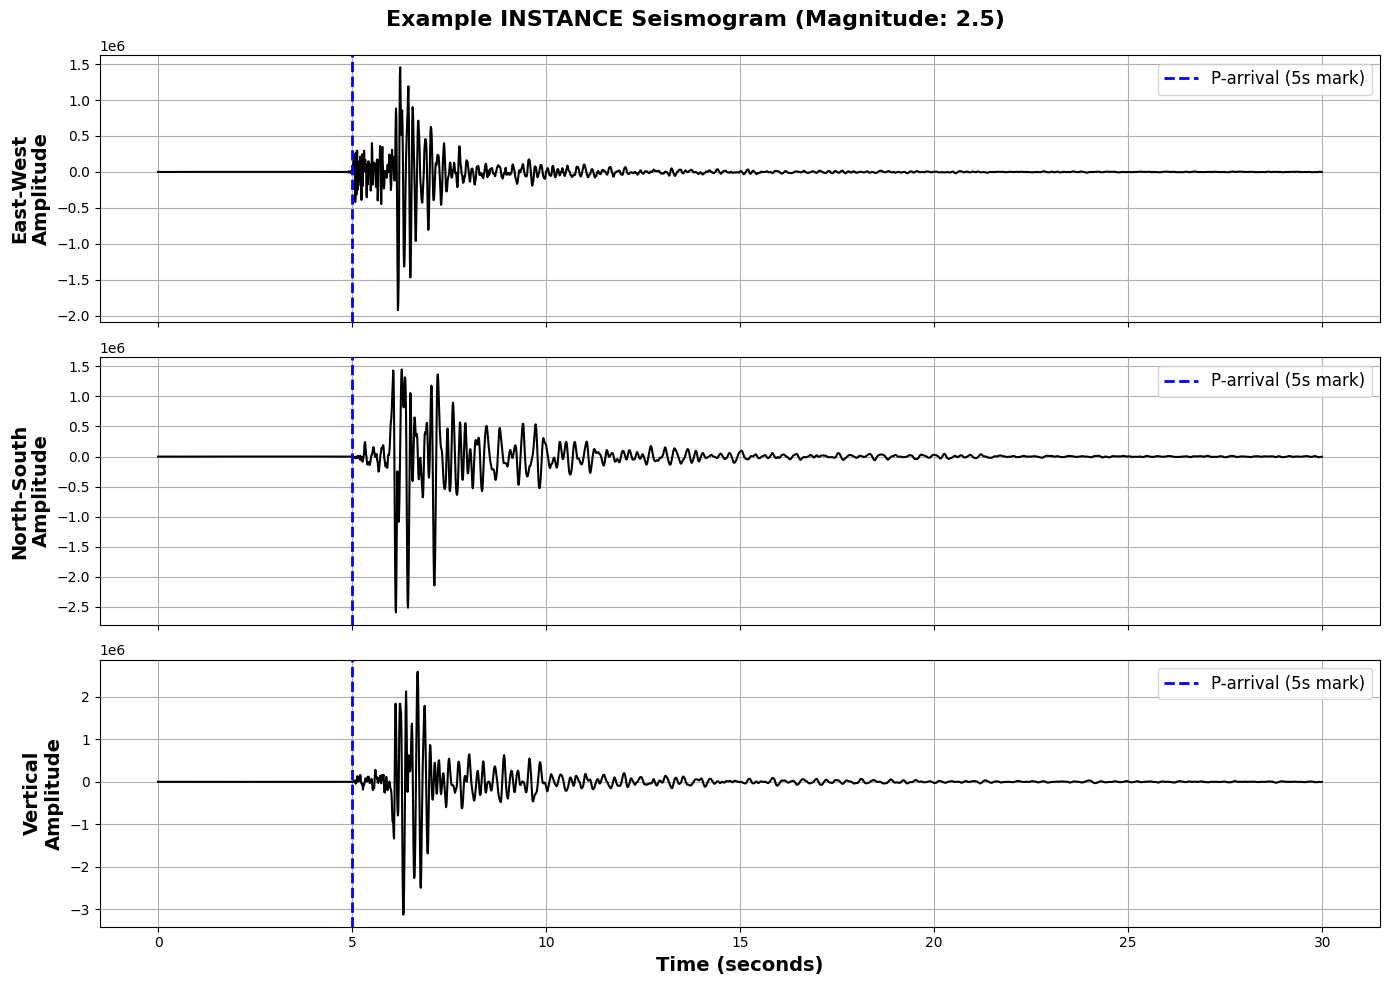

In [ ]:
"""Cell 8: Visualize Example Events"""

# Visualize example events showing all seismograms from the same event
# Find events with multiple seismograms for visualization
events_with_multiple_seismograms = []
for event_id, waveforms in event_waveform_data.items():
    if len(waveforms) > 1:
        events_with_multiple_seismograms.append((event_id, len(waveforms)))

# Sort by number of seismograms (descending)
events_with_multiple_seismograms.sort(key=lambda x: x[1], reverse=True)

# Function to visualize all seismograms from an event
def visualize_event_seismograms_instance(event_id, max_seismograms=6):
    """
    Visualize all seismograms from a specific event to show event grouping

    Args:
        event_id: ID of the event to visualize
        max_seismograms: Maximum number of seismograms to display
    """
    waveforms = event_waveform_data[event_id]
    event_info = event_metadata.get(event_id, {})

    # Limit the number of seismograms to display
    num_seismograms = min(len(waveforms), max_seismograms)
    waveforms = waveforms[:num_seismograms]

    # Create a figure with subplots for each seismogram (3 components each)
    fig = plt.figure(figsize=(15, num_seismograms * 5))
    fig.suptitle(f"Event ID: {event_id}\nMagnitude: {event_info.get('magnitude', 'N/A')}, "
                f"Depth: {event_info.get('depth', 'N/A')} km\n"
                f"Location: ({event_info.get('latitude', 'N/A')}, {event_info.get('longitude', 'N/A')})\n"
                f"Total Seismograms: {len(event_waveform_data[event_id])}",
                fontsize=16, fontweight='bold')

    components = ['East-West', 'North-South', 'Vertical']
    time = np.arange(3000) / 100  # Convert to seconds (100Hz sampling)

    for i, waveform in enumerate(waveforms):
        data = waveform['data']
        seis_id = waveform['seismogram_id']

        for j in range(3):
            ax = fig.add_subplot(num_seismograms, 3, i*3 + j + 1)
            ax.plot(time, data[j, :], 'k')

            ax.set_title(f"Seismogram {i+1} - {components[j]}")
            ax.set_xlabel('Time (seconds)')
            ax.set_ylabel('Amplitude')
            ax.axvline(x=5.0, color='blue', linestyle='--', linewidth=1, label='P-arrival')
            ax.grid(True)

            # Only add legend to the first subplot
            if i == 0 and j == 0:
                ax.legend()

            # Add seismogram ID as a text annotation
            if j == 2:  # Add to the vertical component only
                ax.annotate(f"ID: {seis_id}", xy=(0.5, -0.4), xycoords='axes fraction',
                            fontsize=10, ha='center')

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for the suptitle
    plt.savefig(os.path.join(output_dir, f'event_{event_id}_seismograms.png'), dpi=150)
    plt.show()

# Visualize a few events with multiple seismograms
print("\nVisualizing example events with multiple seismograms:")
for i, (event_id, count) in enumerate(events_with_multiple_seismograms[:3]):
    print(f"Example {i+1}: Event {event_id} with {count} seismograms")
    visualize_event_seismograms_instance(event_id)

# Plot an example single seismogram
def plot_example_seismogram_instance(data, index=0):
    """Plot an example three-component seismogram"""
    fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
    time = np.arange(data.shape[2]) / 100  # Convert to seconds (100Hz sampling)
    components = ['East-West', 'North-South', 'Vertical']

    for i in range(3):
        axes[i].plot(time, data[index, i, :], 'k')
        axes[i].set_ylabel(f'{components[i]}\nAmplitude', fontweight='bold', fontsize=14)
        axes[i].axvline(x=5.0, color='blue', linestyle='--', linewidth=2,
                      label='P-arrival (5s mark)')
        axes[i].grid(True)
        axes[i].legend(fontsize=12)

    axes[2].set_xlabel('Time (seconds)', fontweight='bold', fontsize=14)
    plt.suptitle(f'Example INSTANCE Seismogram (Magnitude: {all_labels[index]})',
                fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot an example seismogram
if len(all_data) > 0:
    plot_example_seismogram_instance(all_data)

Cell 9: Save Data and Create Split Information

In [ ]:
"""Cell 9: Save Data and Create Split Information"""

# Convert to tensors
all_data_tensor = torch.tensor(all_data, dtype=torch.float32)
all_labels_tensor = torch.tensor(all_labels, dtype=torch.float32)

# Save the entire dataset and associated event IDs
print("Saving data files...")
torch.save(all_data_tensor, os.path.join(output_dir, 'all_data.pt'))
torch.save(all_labels_tensor, os.path.join(output_dir, 'all_labels.pt'))

# Save the mapping between indices and event IDs for future reference
with open(os.path.join(output_dir, 'index_to_event_id.pkl'), 'wb') as f:
    pickle.dump({
        'all_event_ids': all_event_ids,
        'event_to_seismograms': valid_event_to_seismograms,
        'event_metadata': event_metadata
    }, f)

# Create function to generate the splits file without using seeds
# This file will be used by the second notebook which will apply its own seeds
def generate_event_based_split_indices(all_event_ids, train_ratio=0.7, val_ratio=0.1):
    """
    Generate the splits file without applying any shuffling
    The second notebook will handle the randomization with specific seeds

    Args:
        all_event_ids: Array of event IDs corresponding to each seismogram
        train_ratio: Proportion for training set
        val_ratio: Proportion for validation set

    Returns:
        Dictionary with unique events and their corresponding seismogram indices
    """
    # Get unique event IDs (maintaining order)
    unique_events = []
    for event_id in all_event_ids:
        if event_id not in unique_events:
            unique_events.append(event_id)

    unique_events = np.array(unique_events)
    print(f"Found {len(unique_events)} unique events for split preparation")

    # Get the indices for each event
    event_indices = {}
    for event_id in unique_events:
        indices = np.where(all_event_ids == event_id)[0]
        event_indices[event_id] = indices

    return {
        'unique_events': unique_events,
        'event_indices': event_indices,
        'train_ratio': train_ratio,
        'val_ratio': val_ratio
    }

# Generate the splits file (without applying randomization)
print("Preparing split information for second notebook...")
split_info = generate_event_based_split_indices(all_event_ids)

# Save the split information
with open(os.path.join(output_dir, 'event_split_info.pkl'), 'wb') as f:
    pickle.dump(split_info, f)

Saving data files...
Preparing split information for second notebook...
Found 28966 unique events for split preparation


Cell 10: Summary and Final Statistics

In [ ]:
"""Cell 10: Summary and Final Statistics"""

# Print a summary of what was created
print("\nFiles created in the output directory:")
print(f"1. all_data.pt - All seismogram data tensors")
print(f"2. all_labels.pt - All magnitude labels")
print(f"3. index_to_event_id.pkl - Mapping between indices and event IDs")
print(f"4. event_split_info.pkl - Information for creating random event-based splits")
print(f"5. multi_observations.npy - List of stations with ≥400 observations")
print(f"6. seismogram_indices.pkl - Mapping between indices and seismogram IDs")
print(f"7. Event visualization images (PNG files)")

# Print statistics about the event distribution
seismograms_per_event = [len(event_waveform_data[event_id]) for event_id in event_waveform_data.keys()]
print(f"\nEvent Distribution Statistics:")
print(f"Total events: {len(event_waveform_data)}")
print(f"Total seismograms: {len(all_data)}")
print(f"Average seismograms per event: {np.mean(seismograms_per_event):.2f}")
print(f"Median seismograms per event: {np.median(seismograms_per_event):.0f}")
print(f"Max seismograms per event: {max(seismograms_per_event)}")
print(f"Min seismograms per event: {min(seismograms_per_event)}")

# Print example events for reference
print("\nExample events with multiple seismograms:")
for i, (event_id, count) in enumerate(events_with_multiple_seismograms[:10]):
    print(f"Event {event_id}: {count} seismograms")

# Report execution time
end_time = time.time()
print(f"\nTotal execution time: {(end_time - start_time) / 60:.2f} minutes")

print("\nPreprocessing complete! Now you can run the 50 experiments notebook using the same logic as STEAD.")
print("\nKey differences from STEAD:")
print(f"- INSTANCE average seismograms per event: {np.mean(seismograms_per_event):.2f}")
print(f"- STEAD average seismograms per event: 2.14")
print(f"- INSTANCE may show more pronounced differences between event-based and seismogram-based splitting")

print("\nINSTANCE event-based preprocessing completed successfully!")
print("Used SeisBench download - no Google Drive quota issues!")


Files created in the output directory:
1. all_data.pt - All seismogram data tensors
2. all_labels.pt - All magnitude labels
3. index_to_event_id.pkl - Mapping between indices and event IDs
4. event_split_info.pkl - Information for creating random event-based splits
5. multi_observations.npy - List of stations with ≥400 observations
6. seismogram_indices.pkl - Mapping between indices and seismogram IDs
7. Event visualization images (PNG files)

Event Distribution Statistics:
Total events: 28966
Total seismograms: 181093
Average seismograms per event: 6.25
Median seismograms per event: 3
Max seismograms per event: 39
Min seismograms per event: 1

Example events with multiple seismograms:
Event 8978771: 39 seismograms
Event 8843681: 37 seismograms
Event 9008551: 37 seismograms
Event 10540911: 37 seismograms
Event 10622631: 37 seismograms
Event 10912211: 37 seismograms
Event 10920951: 37 seismograms
Event 15171841: 37 seismograms
Event 7614081: 36 seismograms
Event 7618521: 36 seismograms